# GPT-2 finetuning tutorial 
https://colab.research.google.com/drive/1_8UUlOjd_KnSIxlSdsF72MeSK3lprnbo?usp=sharing#scrollTo=7lsVGXn0XGfl 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# % matplotlib inline

import random
import json
import time
import datetime
import os

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

import torch
torch.manual_seed(64)
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cuda for training


## Data prep

In [2]:
class PoemDataset(Dataset):
  def __init__(self, poems, tokenizer, max_length=768, gpt2_type="gpt2", max_poems=None):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for poem in poems if max_poems is None else poems[:min(max_poems, len(poems))]:

      encodings_dict = tokenizer("<|startoftext|>"+poem+"<|endoftext|>",
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
      self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [3]:
# Loading GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

In [4]:
from image_to_poem.data.kaggle_poems import KagglePoems
data = KagglePoems("../data/kaggle_poems/")

Reading poems:  15%|█▍        | 2096/14331 [00:00<00:01, 6531.88it/s]

Could not read ../data/kaggle_poems/topics/chicago/ChicagoPoemsOfComptonImNotTheLeastBitAfraidToTheThoughtOfChicagoIDrinkCoolAideOrLemonadeCosaNostraByThemICouldNeverDieTheFbiLikeStandingNextToAFlyPoembyJoshuaAaronGuillory.txt
Could not read ../data/kaggle_poems/topics/chicago/ChicagoPoemsOfComptonImNotTheLeastBitAfraidToTheThoughtOfChicagoIDrinkKoolAidOrLemonadeCosaNostraByThemICouldNeverDieTheFbiLikeStandingNextToAFlyPoembyJoshuaAaronGuillory.txt


Reading poems:  76%|███████▋  | 10961/14331 [00:01<00:00, 6673.43it/s]

Could not read ../data/kaggle_poems/topics/racism/RacismPoemsTranslationOfRacismIsAroundMeEverywhereByFrancisDugganαªåαª«αª░αªÜαª░αª¬αª╢αª¢αº£αºƒαªåαª¢αª£αªñαª¼αªªαª¼αª╖αª«αª▓αª½αª░αª¿αª╕αª╕αªíαªùαª¿PoembyAlamSayed.txt


Reading poems: 100%|██████████| 14331/14331 [00:02<00:00, 6052.04it/s]


In [5]:
dataset = PoemDataset(data.poems, tokenizer, max_length=100, max_poems=100)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 90
Number of samples for validation = 10


In [6]:
train_dataset[0]

(tensor([50257,    40,   447,   247,   303, 16399,    25,   290,   477,   262,
          5238,   314,  2982,   198, 35653,  2647, 34976,  7972,    11,   290,
          4269,    11,   290,  6512,    13,   198,  3152,  6205,   508, 25889,
           422, 12788,   284, 12788,   198,    40,   447,   247,   303, 16399,
            25,   616,  2612,   318, 14720,   991,    13,   198,    40,   447,
           247,   303,  3114,    25,   262,  3329,   995,   373,  4077,    26,
           198, 41267, 42251,   290, 18028,   286,  3240,   314,   447,   247,
           303,  1775,    26,   198,  1870,  5788,    11,  7825,   278,   832,
          8539,  1203,  1755,    13,   198,    40,   447,   247,   303,  3114,
            25,   290,   616,  5848,  1865,   890,    82,   329,  1657,    13]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [7]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=8)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=8)

## Finetune GPT2 Language Model

### Importing Pre-Trained GPT2 Model

In [8]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [9]:
# Setting seeds to enable reproducible runs
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Scheduling Optimizer

In [10]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [11]:
print(len(train_dataloader))
print(len(train_dataset))

12
90


In [12]:
# Using AdamW optimizer with default parameters
optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

c:\Users\lukas\miniconda3\envs\nlp_venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training

In [13]:
def format_time(elapsed):
  return str(datetime.timedelta(seconds=int(round(elapsed))))

In [14]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(epochs):
  print(f'Beginning epoch {epoch_i+1} of {epochs}')

  t0 = time.time()
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss

    # Sampling every x steps
    if step != 0 and step % sample_every == 0:

      elapsed = format_time(time.time()-t0)
      print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

      model.eval()

      sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
      for i, sample_output in enumerate(sample_outputs):
        print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
      print()

      model.train()

    loss.backward()
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time()-t0)
  print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
  print()

  t0 = time.time()
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
            
    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  avg_val_loss = total_eval_loss / len(val_dataloader)  
  val_time = format_time(time.time() - t0)    
  print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
  print()

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Training Time': training_time,
          'Validation Time': val_time
      }
  )
  print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4
Average Training Loss: 47.53901878992716. Epoch time: 0:00:22

Validation loss: 21.39034652709961. Validation Time: 0:00:01

------------------------------
Beginning epoch 2 of 4
Average Training Loss: 6.725579857826233. Epoch time: 0:00:21

Validation loss: 4.6801183223724365. Validation Time: 0:00:01

------------------------------
Beginning epoch 3 of 4
Average Training Loss: 5.413493951161702. Epoch time: 0:00:21

Validation loss: 3.884183168411255. Validation Time: 0:00:01

------------------------------
Beginning epoch 4 of 4
Average Training Loss: 4.5850134293238325. Epoch time: 0:00:21

Validation loss: 3.448719024658203. Validation Time: 0:00:01

------------------------------
Total training took 0:01:30


### Visualizations

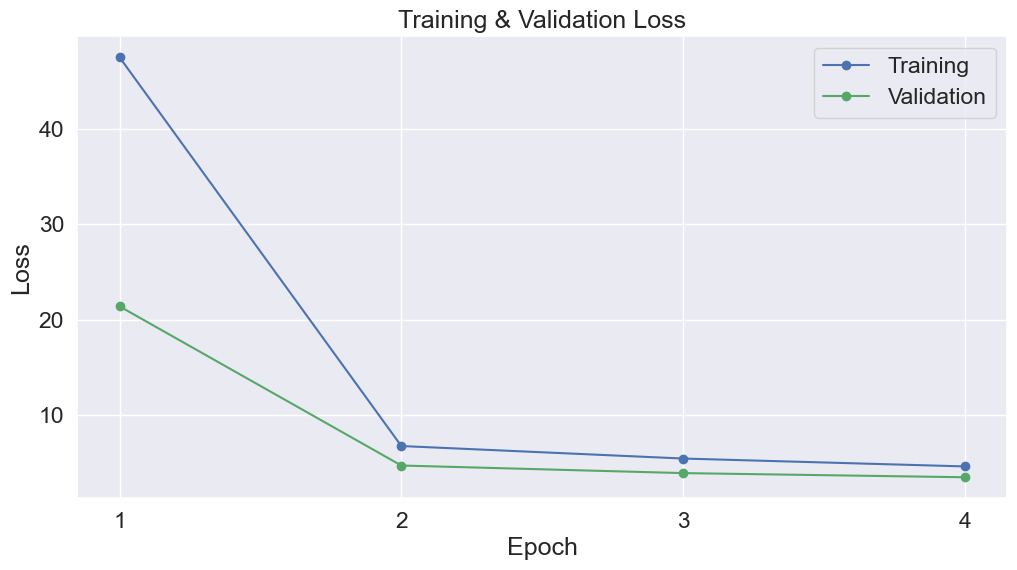

In [17]:
# pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Generating Poems

In [18]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Sis in your soul,I've been so beautiful,The shadow of the night that sleeps for me;
Don't believe in those days of the day
The shadow of my soul,
So many years with I can't drink?

But you've gone out all the tears
But the tears alone with the moon
Who sits on the bed of the morning and a morning in your heart;
From the wind.
Then they come only because I know it so they can
It was a night by night
My name was all of God to do that she will,
And the sun's wrath was,

And I may no need to find

 I can leave all I know
I am no bed and my body,
And I will be gone

I am not alone,
And I cry
And alone alone
And I never will

And I pray so much,And I've gone out,
And I know how to see
And I know I speak
And the path of peace
The one who has left us,
So I know, I do nothing
And I speak;
You don't hide it,
In the morning all my life,
You don't know you know
I am in the dark,

 and I'm alone.
You don't know I don't have,
And I want to know

 I am alone in the dark

Who were you


1: Thereisw

### Saving and Loading Finetuned Model

In [19]:
output_dir = "models/gpt2_tutorial/"
os.makedirs(output_dir, exist_ok=True)

# Save generated poems
# sample_outputs = model.generate(
#                                 generated, 
#                                 do_sample=True,   
#                                 top_k=50, 
#                                 max_length = 300,
#                                 top_p=0.95, 
#                                 num_return_sequences=25
#                                 )

# with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
#   for i, sample_output in enumerate(sample_outputs):
#     outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(training_stats, os.path.join(output_dir, 'training_args.bin'))

('models/gpt2_tutorial/tokenizer_config.json',
 'models/gpt2_tutorial/special_tokens_map.json',
 'models/gpt2_tutorial/vocab.json',
 'models/gpt2_tutorial/merges.txt',
 'models/gpt2_tutorial/added_tokens.json')

In [20]:
# Save generated poems
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=25
                                )

with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
  for i, sample_output in enumerate(sample_outputs):
    outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [21]:
# Loading saved model
model_dir = output_dir

model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

# model = GPT2LMHeadModel.from_pretrained("prajwalcr/poetry-joy_gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("prajwalcr/poetry-joy_gpt2")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)